New best GMM found: n_components=4, covariance_type=full, ARI Score=0.2142230056937609
Overall Best GMM: n_components=4, covariance_type=full, ARI Score=0.2142230056937609


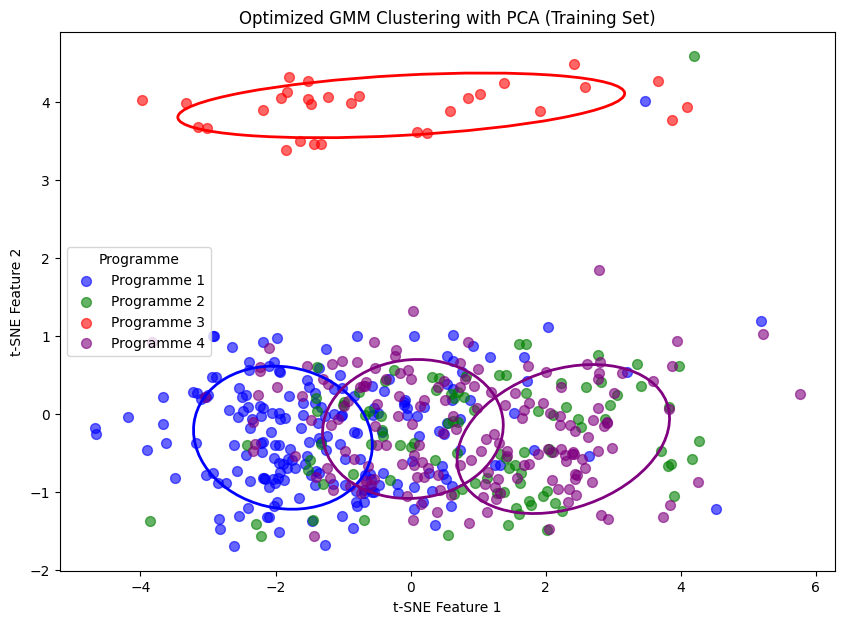

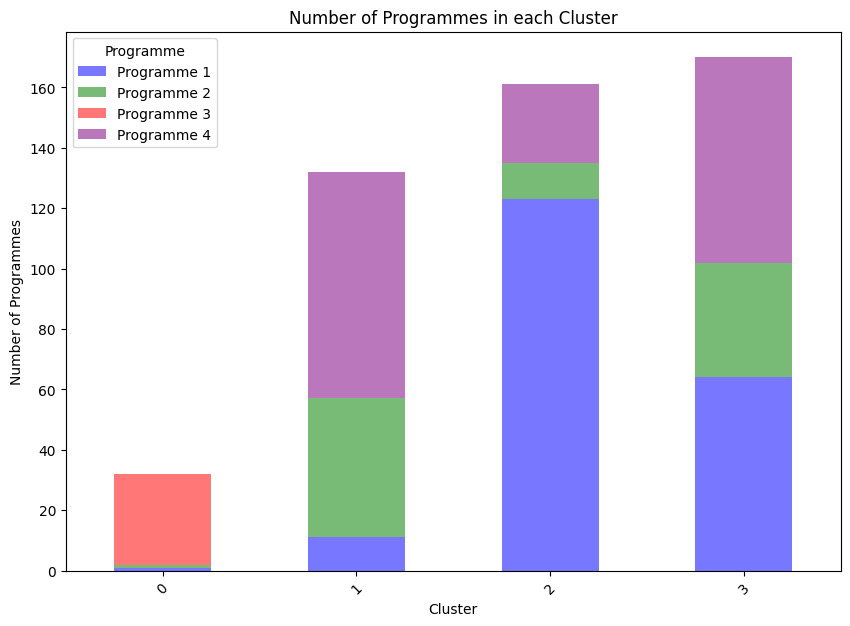

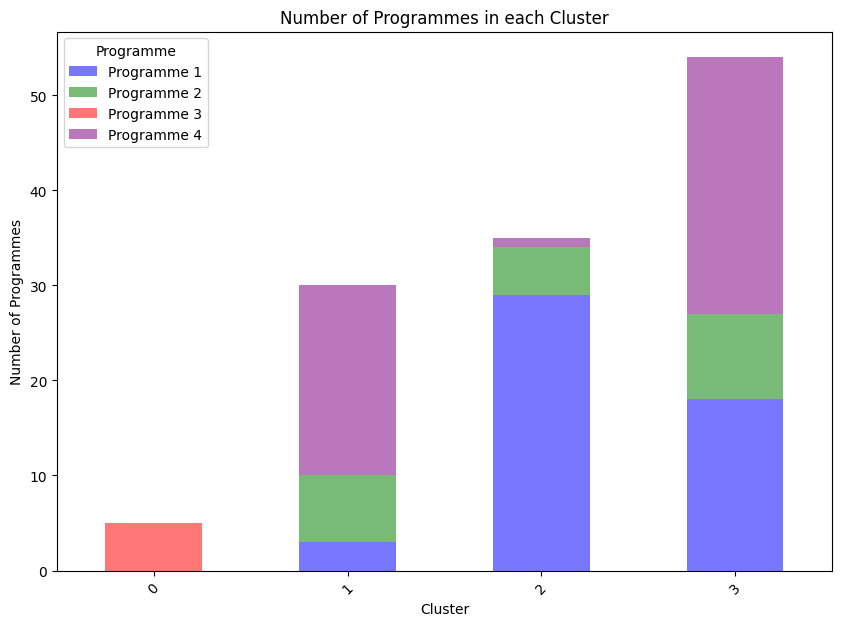

Adjusted Rand Index for the test set: 0.2051122149480279


In [50]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import adjusted_rand_score
from matplotlib.patches import Ellipse




def load_and_preprocess_data(file_path):
    data = pd.read_excel(file_path)
    programme = data.pop('Programme').values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, programme

def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(data)

def optimize_gmm(data, programme):
    best_score = -1  # 初始化为-1，因为ARI的范围是[-1, 1]，我们寻找最大值
    best_gmm = None
    best_params = None
    # 定义不同的协方差类型
    covariance_types = ['full', 'tied', 'diag', 'spherical']
    n_components_range = [4, 5, 6, 7, 8, 9]  # 可以测试的聚类数量范围

    for n_component in n_components_range:
        for covariance_type in covariance_types:
            gmm = GaussianMixture(n_components=n_component, covariance_type=covariance_type, random_state=42)
            gmm.fit(data)
            labels = gmm.predict(data)
            score = adjusted_rand_score(programme, labels)
            if score > best_score:
                best_score = score
                best_gmm = gmm
                best_params = {'n_components': n_component, 'covariance_type': covariance_type}
                print(f"New best GMM found: n_components={n_component}, covariance_type={covariance_type}, ARI Score={score}")

    if best_params:
        print(f'Overall Best GMM: n_components={best_params["n_components"]}, covariance_type={best_params["covariance_type"]}, ARI Score={best_score}')
    return best_gmm, best_params


def plot_tsne_with_clusters_and_contours(data_tsne, labels, programme, title, gmm):
    plt.figure(figsize=(10, 7))
    colors = ['blue', 'green', 'red', 'purple']  # 定义颜色列表
    class_labels = ['Programme 1', 'Programme 2', 'Programme 3', 'Programme 4']  # 类标签
    
    # 绘制每个programme的散点图
    for i, color in zip(range(1, 5), colors):
        idx = np.where(programme == i)
        plt.scatter(data_tsne[idx, 0], data_tsne[idx, 1], color=color, s=50, alpha=0.6, label=class_labels[i-1])

    plt.legend(title='Programme')
    plt.title(title)
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')

    # 绘制概率椭圆表示GMM组件
    for label in np.unique(labels):
        cluster_indices = np.where(labels == label)
        mean = gmm.means_[label]
        covar = gmm.covariances_[label]
        programme_mode = np.bincount(programme[cluster_indices]).argmax()  # 获取最多的programme索引
        ellip_color = colors[programme_mode - 1]  # 使用对应programme的颜色

        eigenvalues, eigenvectors = np.linalg.eigh(covar)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        vx, vy = eigenvectors[:, 0][0], eigenvectors[:, 0][1]
        theta = np.arctan2(vy, vx)
        width, height = 2 * np.sqrt(2) * np.sqrt(eigenvalues)
        ellip = Ellipse(xy=mean, width=width, height=height, angle=np.degrees(theta), edgecolor=ellip_color, lw=2, facecolor='none')
        plt.gca().add_patch(ellip)

    plt.show()




def compute_cluster_programme_counts(data_tsne, labels, programme):
    # 创建一个 DataFrame 来关联 labels 和 programme
    df = pd.DataFrame({'labels': labels, 'programme': programme})
    # 使用 crosstab 来计算每个聚类中每个程序的数量
    return pd.crosstab(df['labels'], df['programme'])

def plot_cluster_programme_bar(cluster_counts):
    # 调淡颜色：通过增加透明度（较高的alpha值表示更不透明，所以使用较低的值）
    colors = ['#0000FF88', '#00800088', '#FF000088', '#80008088']  # 颜色代码后两位表示alpha值，这里设置为88（在00到FF之间）

    class_labels = ['Programme 1', 'Programme 2', 'Programme 3', 'Programme 4']  # 程序标签

    # 绘制每个聚类中的programme数量的条形图
    ax = cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 7), color=colors)
    plt.title('Number of Programmes in each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Programmes')
    plt.xticks(rotation=45)
    plt.legend(title='Programme', labels=class_labels)  # 确保图例标签与class_labels一致
    plt.show()

    
def main():
    file_path = 'CW_Data.xlsx'
    data_scaled, programme = load_and_preprocess_data(file_path)
    
    # 先应用 PCA 到整个数据集
    data_tsne = apply_pca(data_scaled)
    
    # 分割数据为训练和测试集
    train_tsne, test_tsne, train_programme, test_programme = train_test_split(data_tsne, programme, test_size=0.2, random_state=42)
    
    # 训练 GMM
    best_gmm, best_params = optimize_gmm(train_tsne, train_programme)  # 注意添加程序标签数据作为参数
    train_labels = best_gmm.predict(train_tsne)
    test_labels = best_gmm.predict(test_tsne)  # 使用相同的模型来预测测试数据

    # 绘制聚类结果
    plot_tsne_with_clusters_and_contours(train_tsne, train_labels, train_programme, 'Optimized GMM Clustering with PCA (Training Set)', best_gmm)
    
    # 统计并绘制训练集聚类结果中programme的数量
    train_cluster_counts = compute_cluster_programme_counts(train_tsne, train_labels, train_programme)
    plot_cluster_programme_bar(train_cluster_counts)
    
    # 统计并绘制测试集聚类结果中programme的数量
    test_cluster_counts = compute_cluster_programme_counts(test_tsne, test_labels, test_programme)
    plot_cluster_programme_bar(test_cluster_counts)

    # 计算测试集的ARI
    test_ari = adjusted_rand_score(test_programme, test_labels)
    print(f"Adjusted Rand Index for the test set: {test_ari}")

if __name__ == "__main__":
    main()




Testing GMM: n_components=4, covariance_type=full, ARI Score=0.20899158167809478
Testing GMM: n_components=4, covariance_type=tied, ARI Score=0.17407842862153713
Testing GMM: n_components=4, covariance_type=diag, ARI Score=0.19998677203654697
Testing GMM: n_components=4, covariance_type=spherical, ARI Score=0.20067570814740698
Testing GMM: n_components=5, covariance_type=full, ARI Score=0.16388340882387828
Testing GMM: n_components=5, covariance_type=tied, ARI Score=0.18056060908302746
Testing GMM: n_components=5, covariance_type=diag, ARI Score=0.16776109448126536
Testing GMM: n_components=5, covariance_type=spherical, ARI Score=0.16249806470717004
Testing GMM: n_components=6, covariance_type=full, ARI Score=0.16606071541033962
Testing GMM: n_components=6, covariance_type=tied, ARI Score=0.14782597990196056
Testing GMM: n_components=6, covariance_type=diag, ARI Score=0.16062606207398122
Testing GMM: n_components=6, covariance_type=spherical, ARI Score=0.1495375908062383
Testing GMM: n

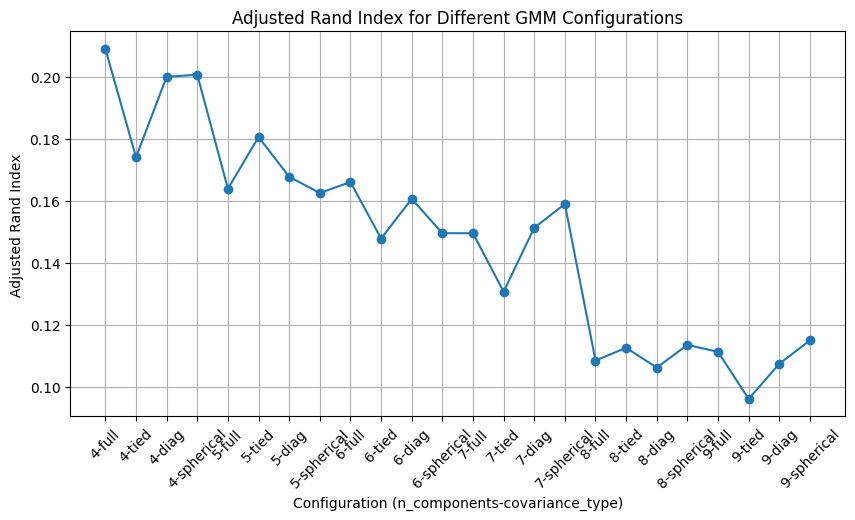

In [52]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

def load_and_preprocess_data(file_path):
    data = pd.read_excel(file_path)
    programme = data.pop('Programme').values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, programme

def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(data)

def optimize_gmm(data, programme):
    results = []
    covariance_types = ['full', 'tied', 'diag', 'spherical']
    n_components_range = [4, 5, 6, 7, 8, 9]  # 可以测试的聚类数量范围

    for n_component in n_components_range:
        for covariance_type in covariance_types:
            gmm = GaussianMixture(n_components=n_component, covariance_type=covariance_type, random_state=42)
            gmm.fit(data)
            labels = gmm.predict(data)
            score = adjusted_rand_score(programme, labels)
            results.append((f"{n_component}-{covariance_type}", score))
            print(f"Testing GMM: n_components={n_component}, covariance_type={covariance_type}, ARI Score={score}")

    return results

def plot_ari_scores(results):
    import matplotlib.pyplot as plt

    params, scores = zip(*results)
    plt.figure(figsize=(10, 5))
    plt.plot(params, scores, marker='o')
    plt.title('Adjusted Rand Index for Different GMM Configurations')
    plt.xlabel('Configuration (n_components-covariance_type)')
    plt.ylabel('Adjusted Rand Index')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

def main():
    file_path = 'CW_Data.xlsx'
    data_scaled, programme = load_and_preprocess_data(file_path)
    
    data_pca = apply_pca(data_scaled)
    results = optimize_gmm(data_pca, programme)
    plot_ari_scores(results)

if __name__ == "__main__":
    main()


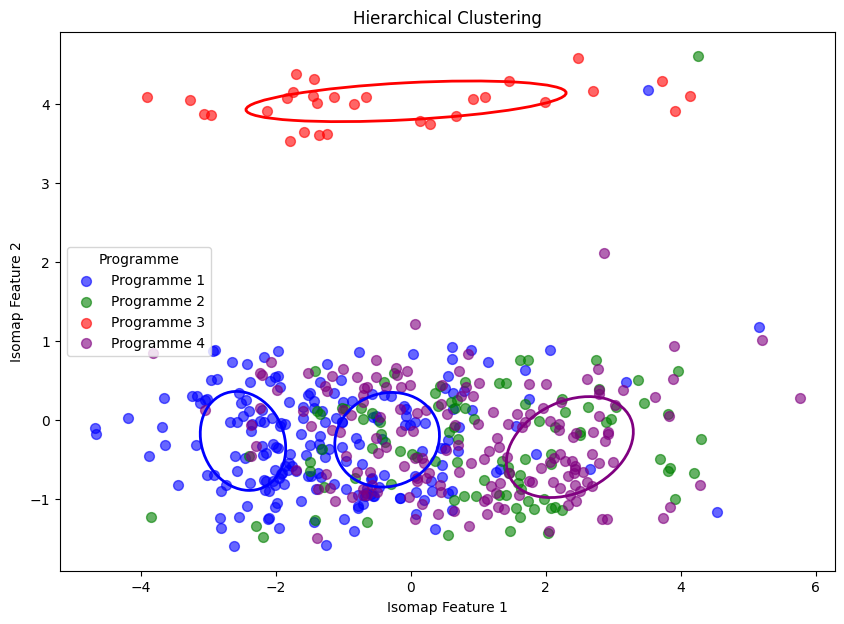

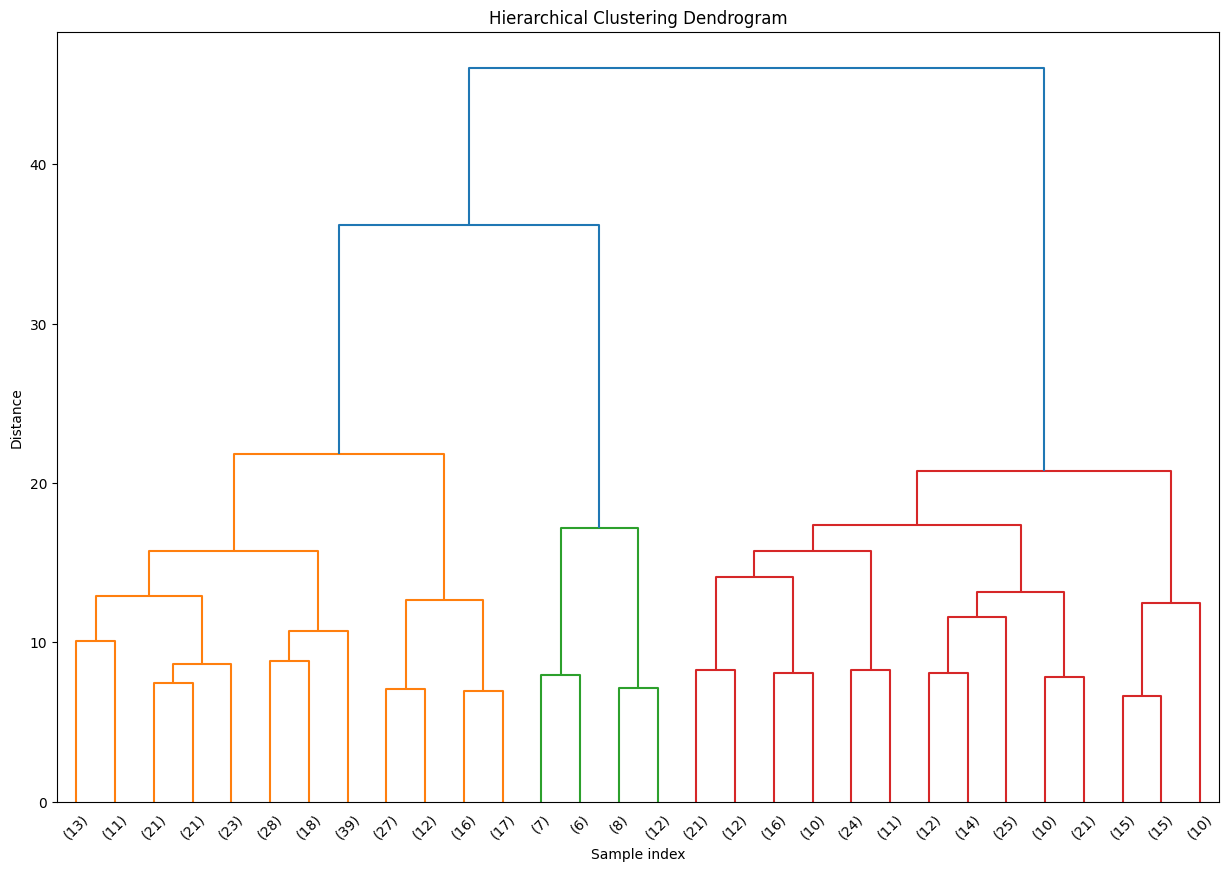

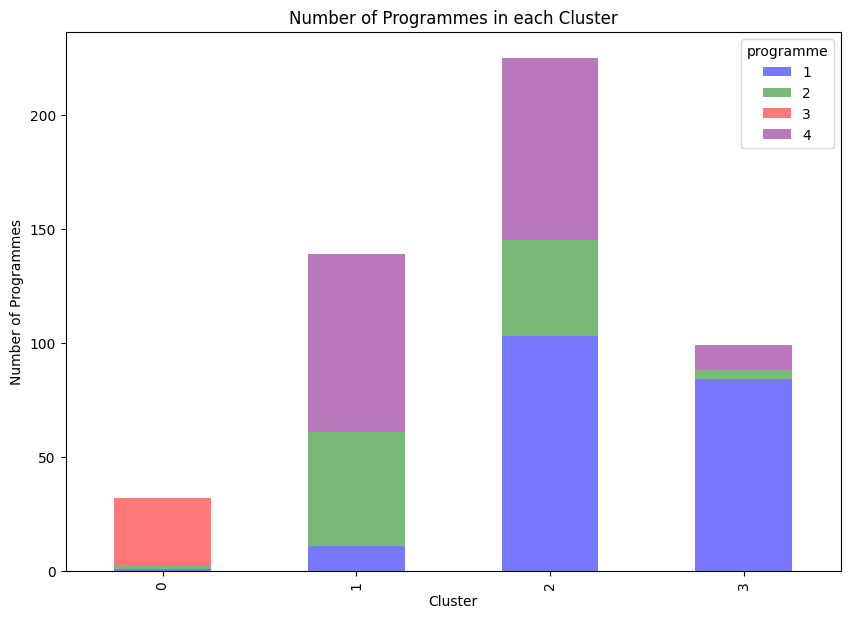

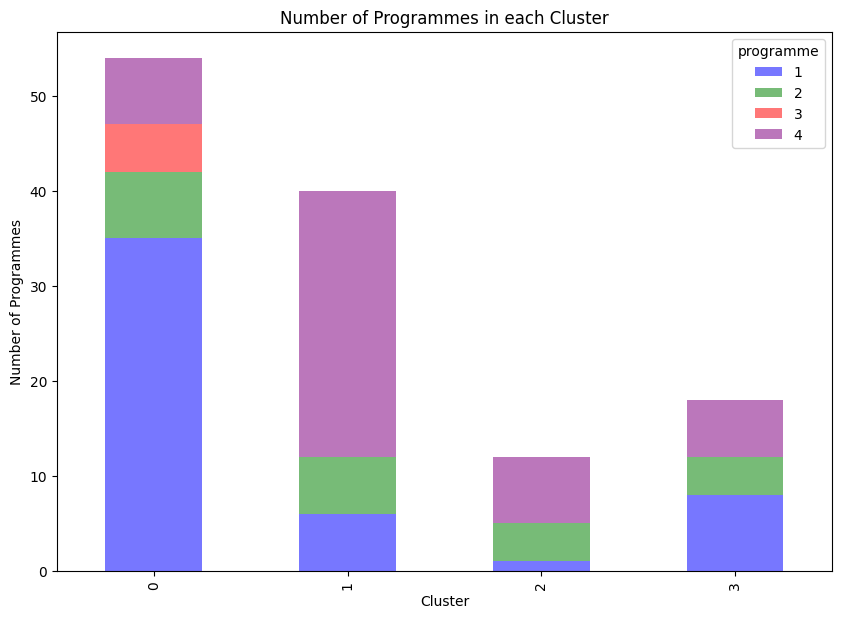

Silhouette Score: 0.4142440490173077
Davies-Bouldin Index: 0.7442246274072934


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

def load_data(file_path):
    data = pd.read_excel(file_path)
    programme = data.pop('Programme').values
    return data, programme

def preprocess_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(data)

def apply_hierarchical_clustering(data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = clustering.fit_predict(data)
    return labels, clustering

def plot_results_with_ellipses(data_isomap, labels, programme, title):
    cmap = ListedColormap(['blue', 'green', 'red', 'purple'])
    plt.figure(figsize=(10, 7))
    color_map = {1: 'blue', 2: 'green', 3: 'red', 4: 'purple'}
    class_labels = ['Programme 1', 'Programme 2', 'Programme 3', 'Programme 4']

    # Scatter plot
    for i, color in zip(range(1, 5), ['blue', 'green', 'red', 'purple']):
        idx = programme == i
        plt.scatter(data_isomap[idx, 0], data_isomap[idx, 1], color=color, s=50, alpha=0.6, label=class_labels[i-1])

    plt.legend(title='Programme')
    plt.title(title)
    plt.xlabel('Isomap Feature 1')
    plt.ylabel('Isomap Feature 2')

    # Draw ellipses
    for label in np.unique(labels):
        cluster_points = data_isomap[labels == label]
        programme_cluster = programme[labels == label]
        if cluster_points.size == 0:
            continue

        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        vx, vy = eigenvectors[:, 0]
        theta = np.degrees(np.arctan2(vy, vx))
        width, height = 2 * np.sqrt(eigenvalues)  # 2 standard deviations

        # Determine the color by voting
        unique, counts = np.unique(programme_cluster, return_counts=True)
        most_frequent = unique[np.argmax(counts)]
        ellipse_color = color_map[most_frequent]

        ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=ellipse_color, lw=2, facecolor='none')
        plt.gca().add_patch(ellipse)

    plt.show()

def plot_dendrogram(data, title):
    linked = linkage(data, 'ward')
    plt.figure(figsize=(15, 10))
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, truncate_mode='lastp', p=30)
    plt.title(title)
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()

def compute_cluster_programme_counts(data, labels, programme):
    df = pd.DataFrame({
        'labels': labels,
        'programme': programme
    })
    return pd.crosstab(df['labels'], df['programme'])

def optimize_hyperparameters(data):
    best_score = float('inf')  # 使用轮廓系数，初始化为无穷大，因为我们希望找到最小的DB指数
    best_params = {}
    n_clusters = 4  # 固定聚类数为4

    # 定义链接和亲和力选项
    linkages = ['ward', 'complete', 'average', 'single']
    affinities = ['euclidean', 'manhattan', 'cosine']

    for linkage in linkages:
        if linkage == 'ward':
            # 'ward' 链接方法只与 'euclidean' 亲和力兼容
            clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity='euclidean')
            labels = clustering.fit_predict(data)
            score = silhouette_score(data, labels)
            if score < best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'linkage': linkage, 'affinity': 'euclidean'}
        else:
            for affinity in affinities:
                clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)
                labels = clustering.fit_predict(data)
                score = silhouette_score(data, labels)
                if score < best_score:
                    best_score = score
                    best_params = {'n_clusters': n_clusters, 'linkage': linkage, 'affinity': affinity}

    return best_params, best_score


def plot_cluster_programme_bar(cluster_counts):
    colors = ['#0000FF88', '#00800088', '#FF000088', '#80008088']  # 颜色代码，包括透明度
    ax = cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 7), color=colors)
    plt.title('Number of Programmes in each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Programmes')
    plt.xticks(rotation=90)
    plt.show()




def main():
    file_path = 'CW_Data.xlsx'
    data, programme = load_data(file_path)
    data_scaled = preprocess_data(data)
    train_data, test_data, train_programme, test_programme = train_test_split(data_scaled, programme, test_size=0.20, random_state=42)

    # 对训练集和测试集应用 Isomap
    train_pca = apply_pca(train_data)
    test_pca = apply_pca(test_data)  # 这是修复的部分

    # 对训练集应用层次聚类
    train_labels, clustering = apply_hierarchical_clustering(train_pca, n_clusters=4)
    # 对测试集应用层次聚类
    test_labels, _ = apply_hierarchical_clustering(test_pca, n_clusters=4)  # 确保也为测试集进行聚类

    # 绘制训练集的聚类结果和树状图
    plot_results_with_ellipses(train_pca, train_labels, train_programme, 'Hierarchical Clustering')
    plot_dendrogram(train_data, 'Hierarchical Clustering Dendrogram')

    # 计算评估指标
    sil_score = silhouette_score(train_pca, train_labels)
    db_score = davies_bouldin_score(train_pca, train_labels)

    # 计算并绘制训练集中每个聚类的programme数量
    train_cluster_counts = compute_cluster_programme_counts(train_pca, train_labels, train_programme)
    plot_cluster_programme_bar(train_cluster_counts)
    
    # 计算并绘制测试集中每个聚类的programme数量
    test_cluster_counts = compute_cluster_programme_counts(test_pca, test_labels, test_programme)
    plot_cluster_programme_bar(test_cluster_counts)

    print(f'Silhouette Score: {sil_score}')
    print(f'Davies-Bouldin Index: {db_score}')

if __name__ == "__main__":
    main()



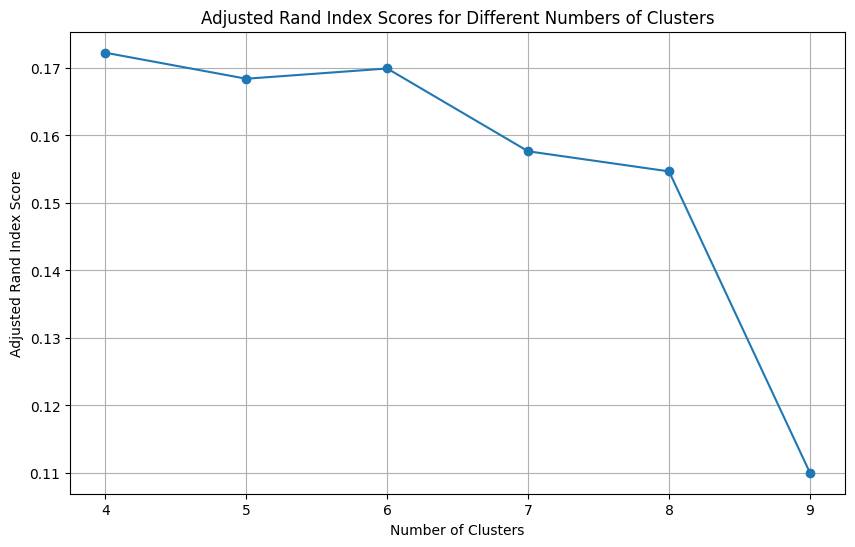

Adjusted Rand Index Scores:
{4: 0.1722508343019321, 5: 0.16839704559850546, 6: 0.16991672893337056, 7: 0.1576491918162898, 8: 0.15467193829080852, 9: 0.11003382782029236}


In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_data(file_path):
    data = pd.read_excel(file_path)
    programme = data.pop('Programme').values
    return data, programme

def preprocess_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(data)

def apply_hierarchical_clustering(data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = clustering.fit_predict(data)
    return labels

def evaluate_clusters(data, programme, n_clusters_start, n_clusters_end):
    ari_scores = {}
    for n_clusters in range(n_clusters_start, n_clusters_end+1):
        labels = apply_hierarchical_clustering(data, n_clusters)
        ari_score = adjusted_rand_score(programme, labels)
        ari_scores[n_clusters] = ari_score
    return ari_scores

def plot_ari_scores(ari_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(list(ari_scores.keys()), list(ari_scores.values()), marker='o', linestyle='-')
    plt.title('Adjusted Rand Index Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Adjusted Rand Index Score')
    plt.grid(True)
    plt.show()

def main():
    file_path = 'CW_Data.xlsx'
    data, programme = load_data(file_path)
    data_scaled = preprocess_data(data)
    data_pca = apply_pca(data_scaled)
    
    # 评估聚类的效果
    ari_scores = evaluate_clusters(data_pca, programme, 4, 9)
    
    # 绘制ARI得分图
    plot_ari_scores(ari_scores)
    
    print("Adjusted Rand Index Scores:")
    print(ari_scores)

if __name__ == "__main__":
    main()


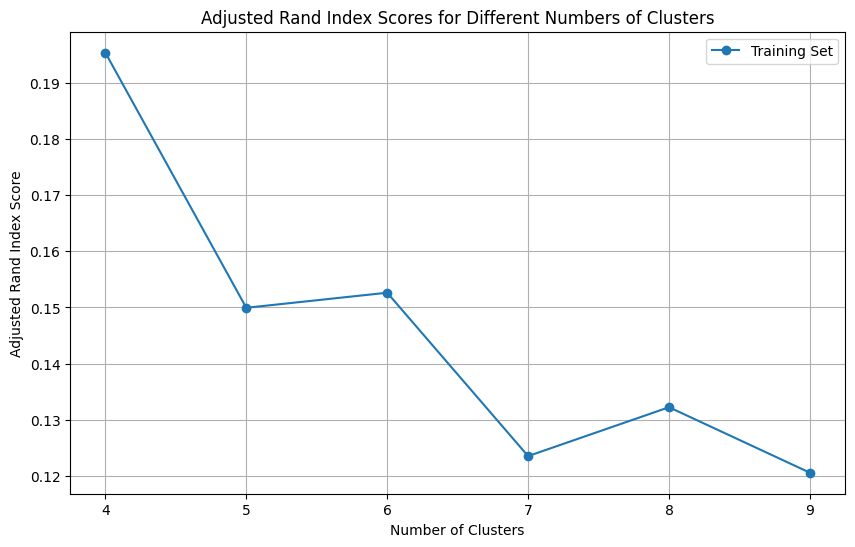

Training Set ARI Scores:
{4: 0.19530072068506663, 5: 0.14994330307835732, 6: 0.15262109668176993, 7: 0.12356893168557431, 8: 0.13225916502831625, 9: 0.12061138325087528}


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_and_preprocess_data(file_path):
    data = pd.read_excel(file_path)
    programme = data.pop('Programme').values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, programme

def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(data)

def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    return labels

def perform_grid_search(data, programme):
    n_components_list = range(4, 10)  # 从4到9个簇
    ari_scores = {}
    for n_clusters in n_components_list:
        labels = apply_kmeans(data, n_clusters)
        ari = adjusted_rand_score(programme, labels)
        ari_scores[n_clusters] = ari
    return ari_scores

def plot_ari_scores(ari_scores_train):
    plt.figure(figsize=(10, 6))
    plt.plot(list(ari_scores_train.keys()), list(ari_scores_train.values()), marker='o', label='Training Set')
    plt.title('Adjusted Rand Index Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Adjusted Rand Index Score')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    file_path = 'CW_Data.xlsx'
    data_scaled, programme = load_and_preprocess_data(file_path)
    data_pca = apply_pca(data_scaled)
    
    # 使用训练集
    train_data, _, train_programme, _ = train_test_split(data_pca, programme, test_size=0.2, random_state=42)
    
    # 对训练集进行网格搜索
    train_ari_scores = perform_grid_search(train_data, train_programme)

    # 绘制训练集的ARI得分
    plot_ari_scores(train_ari_scores)

    print("Training Set ARI Scores:")
    print(train_ari_scores)

if __name__ == "__main__":
    main()


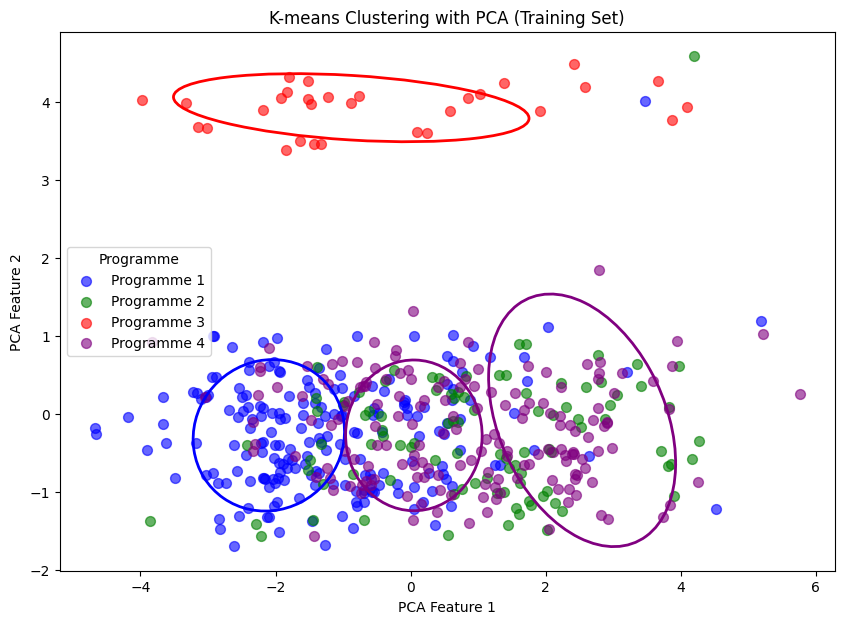

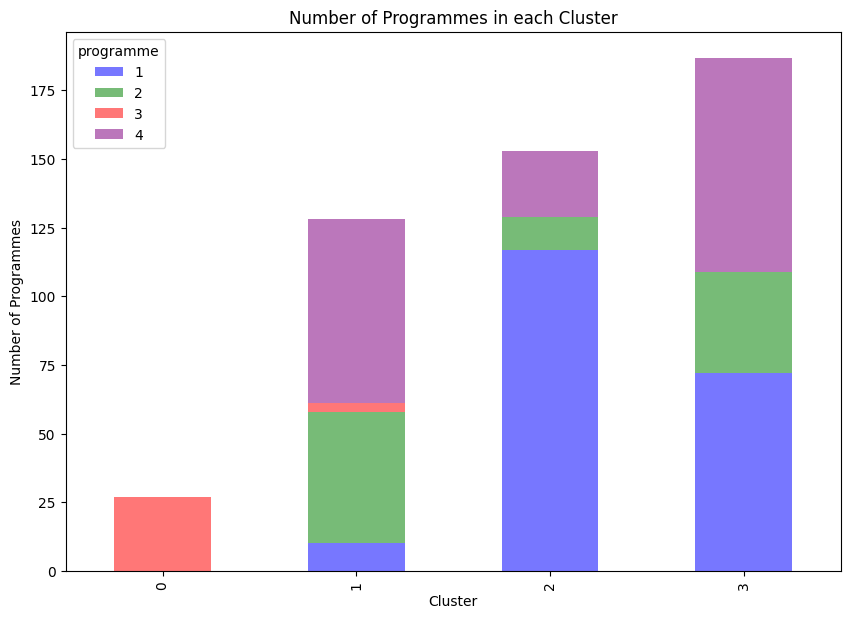

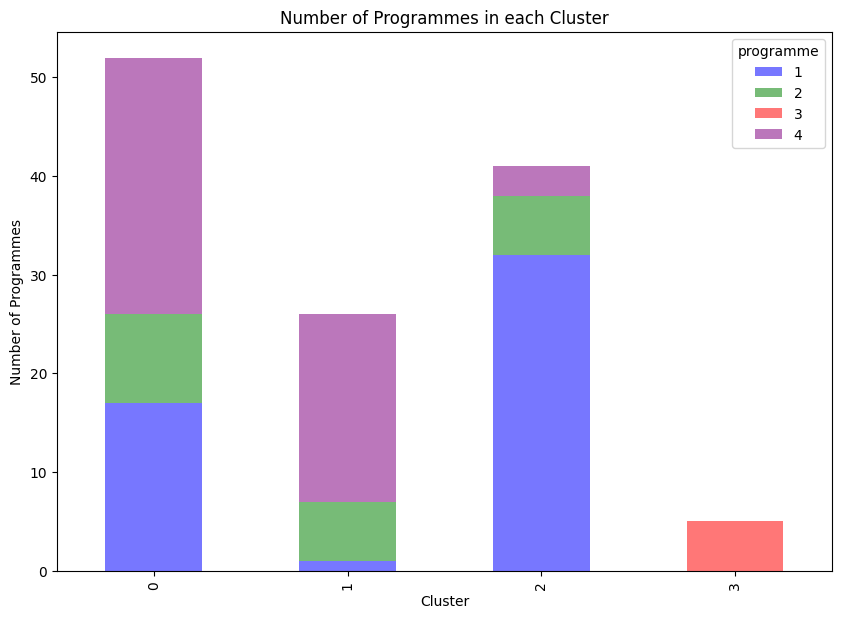

Adjusted Rand Index for the test set: 0.21889545582472775


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def load_and_preprocess_data(file_path):
    data = pd.read_excel(file_path)
    programme = data.pop('Programme').values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, programme

def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(data)

def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    return kmeans, labels


def plot_tsne_with_clusters_and_contours(data_tsne, labels, programme, title, kmeans):
    plt.figure(figsize=(10, 7))
    colors = ['blue', 'green', 'red', 'purple']
    class_labels = ['Programme 1', 'Programme 2', 'Programme 3', 'Programme 4']
    
    # Plot each programme's data points
    for i, color in zip(range(1, 5), colors):
        idx = np.where(programme == i)
        plt.scatter(data_tsne[idx, 0], data_tsne[idx, 1], color=color, s=50, alpha=0.6, label=class_labels[i-1])
    
    plt.legend(title='Programme')
    plt.title(title)
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    
    # Plot centroids as large stars
    centroids = kmeans.cluster_centers_
    
    # Plot ellipses
    for i, center in enumerate(centroids):
        cluster_points = data_tsne[labels == i]
        programme_cluster = programme[labels == i]
        
        if cluster_points.size == 0:
            continue
        
        # Voting for color
        unique, counts = np.unique(programme_cluster, return_counts=True)
        most_frequent = unique[np.argmax(counts)]
        ellipse_color = colors[most_frequent - 1]  # Assume programme labels start at 1
        
        # Calculate covariance and plot ellipse
        cov = np.cov(cluster_points, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0]))
        width, height = 3 * np.sqrt(eigenvalues[:2])  # 3 std deviations for larger ellipses
        
        ellipse = Ellipse(xy=center, width=width, height=height, angle=angle,
                          edgecolor=ellipse_color, lw=2, facecolor='none')
        plt.gca().add_patch(ellipse)
    
    plt.show()



def compute_cluster_programme_counts(data_tsne, labels, programme):
    df = pd.DataFrame({'labels': labels, 'programme': programme})
    return pd.crosstab(df['labels'], df['programme'])

def plot_cluster_programme_bar(cluster_counts):
    colors = ['#0000FF88', '#00800088', '#FF000088', '#80008088'] 
    cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 7), color=colors)
    plt.title('Number of Programmes in each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Programmes')
    plt.show()

def main():
    file_path = 'CW_Data.xlsx'
    data_scaled, programme = load_and_preprocess_data(file_path)
    data_pca = apply_pca(data_scaled)
    
    train_pca, test_pca, train_programme, test_programme = train_test_split(data_pca, programme, test_size=0.2, random_state=42)
    
    n_clusters = 4  # Choose a number of clusters
    kmeans_train, train_labels = apply_kmeans(train_pca, n_clusters)
    kmeans_test, test_labels = apply_kmeans(test_pca, n_clusters)

    plot_tsne_with_clusters_and_contours(train_pca, train_labels, train_programme, 'K-means Clustering with PCA (Training Set)', kmeans_train)
    
    train_cluster_counts = compute_cluster_programme_counts(train_pca, train_labels, train_programme)
    plot_cluster_programme_bar(train_cluster_counts)
    
    test_cluster_counts = compute_cluster_programme_counts(test_pca, test_labels, test_programme)
    plot_cluster_programme_bar(test_cluster_counts)

    test_ari = adjusted_rand_score(test_programme, test_labels)
    print(f"Adjusted Rand Index for the test set: {test_ari}")

if __name__ == "__main__":
    main()
